# Game of "Yes, no, black, white"
In this notebook we propose a *toy experiment* to see if the tuned lens reveal the internal representation of the model.
Inspired by the example on translation, we expect that in the intermediate layers the tokens represent the 
internal representation of the model, while the last layers enable the model to format its answer according to user 
specified constraints.

We propose to play a simplified version of *the game "Yes, no, black, white"* ("Ni oui ni non" in French), where the model can only answer 
using one word.
The idea is to look at the most probable words in the intermediate layers of the model to see if a forbidden word appears. If it is case, 
it could support the idea that the intermediate layers enable the model to have a good representation of what it will output and the last layers 
only help to format the answer.

We compare the results with a setting where we ask the model to answer only in one word, allowing it to use any word.

We use the pre-trained tuned lens of Llama-3-8B-Instruct available on the [HuggingFace repository of the authors](https://huggingface.co/spaces/AlignmentResearch/tuned-lens/tree/main).

A limitation of this experiment is that we ask the model to answer in one word in both cases, because otherwise the comparison would not be as easy. 
Further work could attempt to extend these experiments to a more realistic setting where we want the model to output a full response.

In [1]:
# Needed package to manage the HuggingFace token
# Add your HuggingFace token in a .env file located at the root of this repo
!pip install python-dotenv

In [2]:
import os
from dotenv import load_dotenv

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from tuned_lens.nn.lenses import TunedLens, LogitLens
from tuned_lens.plotting import PredictionTrajectory


/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = os.path.join(os.path.dirname(os.getcwd()), '.env')
load_dotenv(path)
HF_TOKEN = os.environ.get("HF_TOKEN")
device = torch.device('cpu')
model = AutoModelForCausalLM.from_pretrained('meta-llama/Meta-Llama-3-8B-Instruct', token=HF_TOKEN)
model = model.to(device)
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3-8B-Instruct', token=HF_TOKEN)

Loading checkpoint shards: 100%|██████████| 4/4 [00:15<00:00,  3.80s/it]


In [4]:
tuned_lens = TunedLens.from_model_and_pretrained(model)
tuned_lens = tuned_lens.to(device)
logit_lens = LogitLens.from_model(model)

Our input prompt, explaining the rules to the LLM:
```
Let us play the game Yes, no, black, white. I am the questioner. I will ask you a question, and you will answer truthfully to that without using any of the four forbidden words: yes, no, black or white. If you use one of the forbidden words, you lose. I also add a constraint: your answer must be only one word. Alright?
```

In [5]:
messages = [
    {"role": "user", "content": "Let us play the game Yes, no, black, white. I am the questioner. I will ask you a question, and you will answer truthfully to that without using any of the four forbidden words: yes, no, black or white. If you use one of the forbidden words, you lose. I also add a constraint: your answer must be only one word. Alright?"},
]

input_dict = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True
).to(model.device)

input_ids = input_dict['input_ids']
attn_mask = input_dict['attention_mask']

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
    input_ids,
    attention_mask=attn_mask,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

Sounds like a fun challenge! I'm ready to play. Go ahead and ask your question!


The prompt for the control experiment, where any word is allowed:
```
Let us play a game. I am the questioner. I will ask you a question, and you will answer truthfully to that. I also add a constraint: your answer must be only one word. Alright?
```

In [6]:
messages = [
    {"role": "user", "content": "Let us play a game. I am the questioner. I will ask you a question, and you will answer truthfully to that. I also add a constraint: your answer must be only one word. Alright?"},
]

input_dict = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True
).to(model.device)

input_ids = input_dict['input_ids']
attn_mask = input_dict['attention_mask']

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
    input_ids,
    attention_mask=attn_mask,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

Sounds like fun! I'm ready to play. What's the first question?


Due to computational costs, we do not consider longer conversations than 2 prompts and 2 answers.

## First example: Are vegetables healthy?

### Yes, no, black, white

In [7]:
messages = [
    {"role": "user", "content": "Let us play the game Yes, no, black, white. I am the questioner. I will ask you a question, and you will answer truthfully to that without using any of the four forbidden words: yes, no, black or white. If you use one of the forbidden words, you lose. I also add a constraint: your answer must be only one word. Alright?"},
    {"role": "assistant", "content": "Sounds like a fun challenge! I'm ready to play. Go ahead and ask your question!"},
    {"role": "user", "content": "Are vegetables healthy?"}
]

input_dict = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True
).to(model.device)

input_ids = input_dict['input_ids']
attn_mask = input_dict['attention_mask']

outputs = model.generate(
    input_ids,
    attention_mask=attn_mask,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

Nutritious


In [9]:
token_range = slice(len(input_ids[0])-1, len(input_ids[0]))

text_ids = torch.cat((input_ids[0], response))

pred_traj = PredictionTrajectory.from_lens_and_model(
    lens=tuned_lens,
    model=model,
    input_ids=text_ids.tolist(),
    tokenizer=tokenizer,
    targets=text_ids[1:].tolist() + [tokenizer.eos_token_id],
).slice_sequence(token_range)

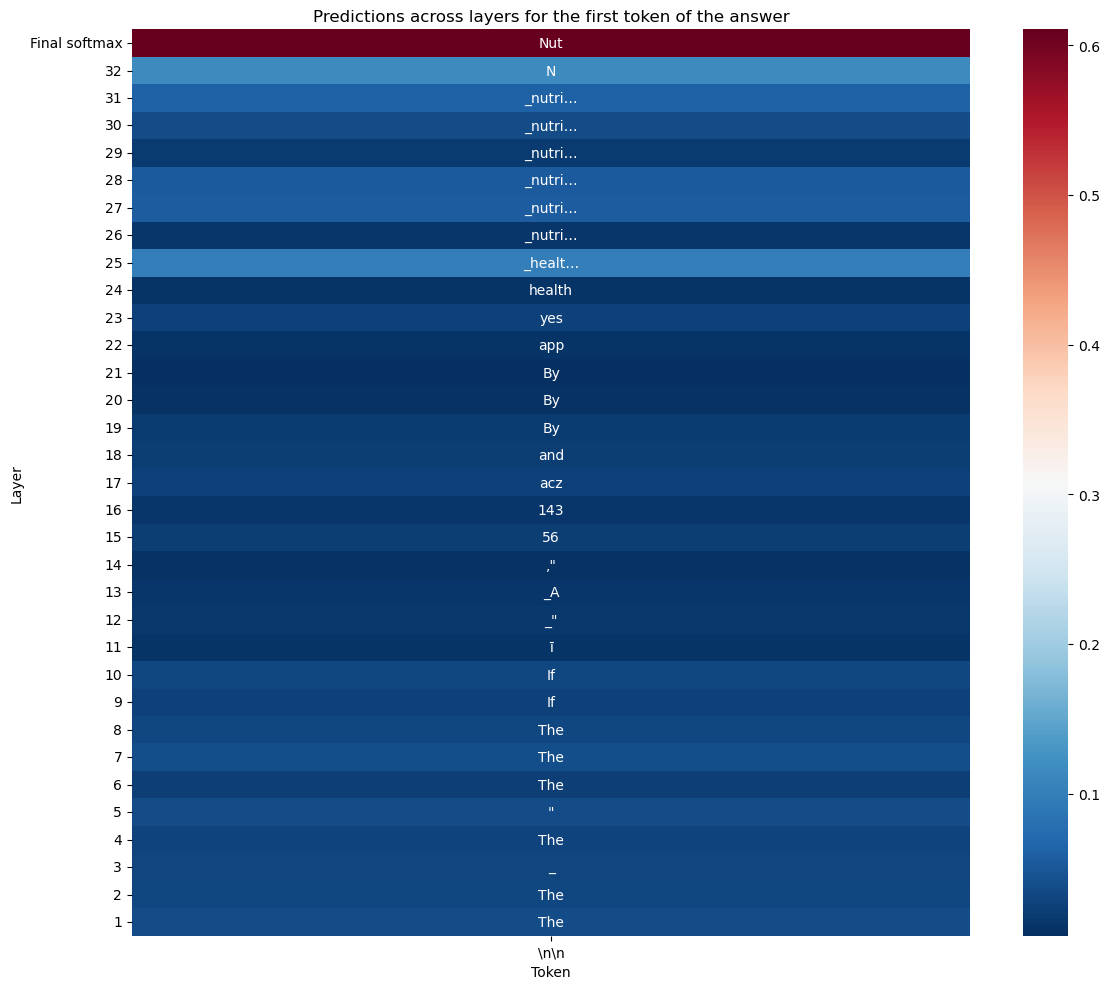

In [12]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
tokens = pred_traj.max_probability().sequence_labels

stats = pred_traj.max_probability().stats[::-1, :]
preds = pred_traj.max_probability().trajectory_labels.label_strings[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))

# Create the heatmap using seaborn
ax = sns.heatmap(stats, cmap="RdBu_r", annot=preds, 
                fmt="", cbar=True)

# Set labels and title
ax.set_xlabel('Token')
ax.set_ylabel('Layer')
ax.set_title('Predictions across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(stats), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, stats.shape[1], 1))
ax.set_xticklabels(tokens)

# Adjust layout
plt.tight_layout()
plt.show()

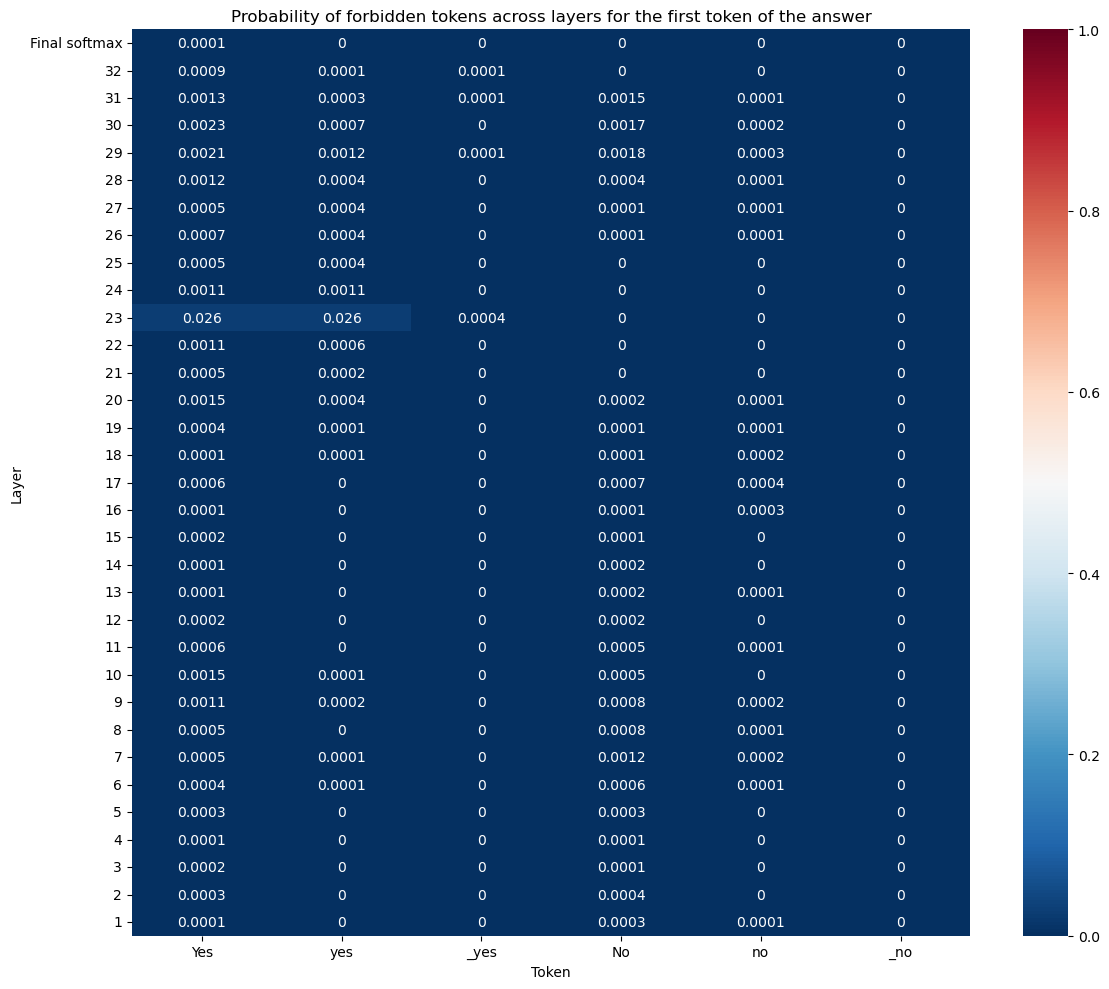

In [11]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
probs = np.vstack([pred_traj.probs[:, 0, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=probs.round(4), cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()

In [15]:
order = (-pred_traj.probs[:, 0, :]).argsort()
ranks = order.argsort() + 1

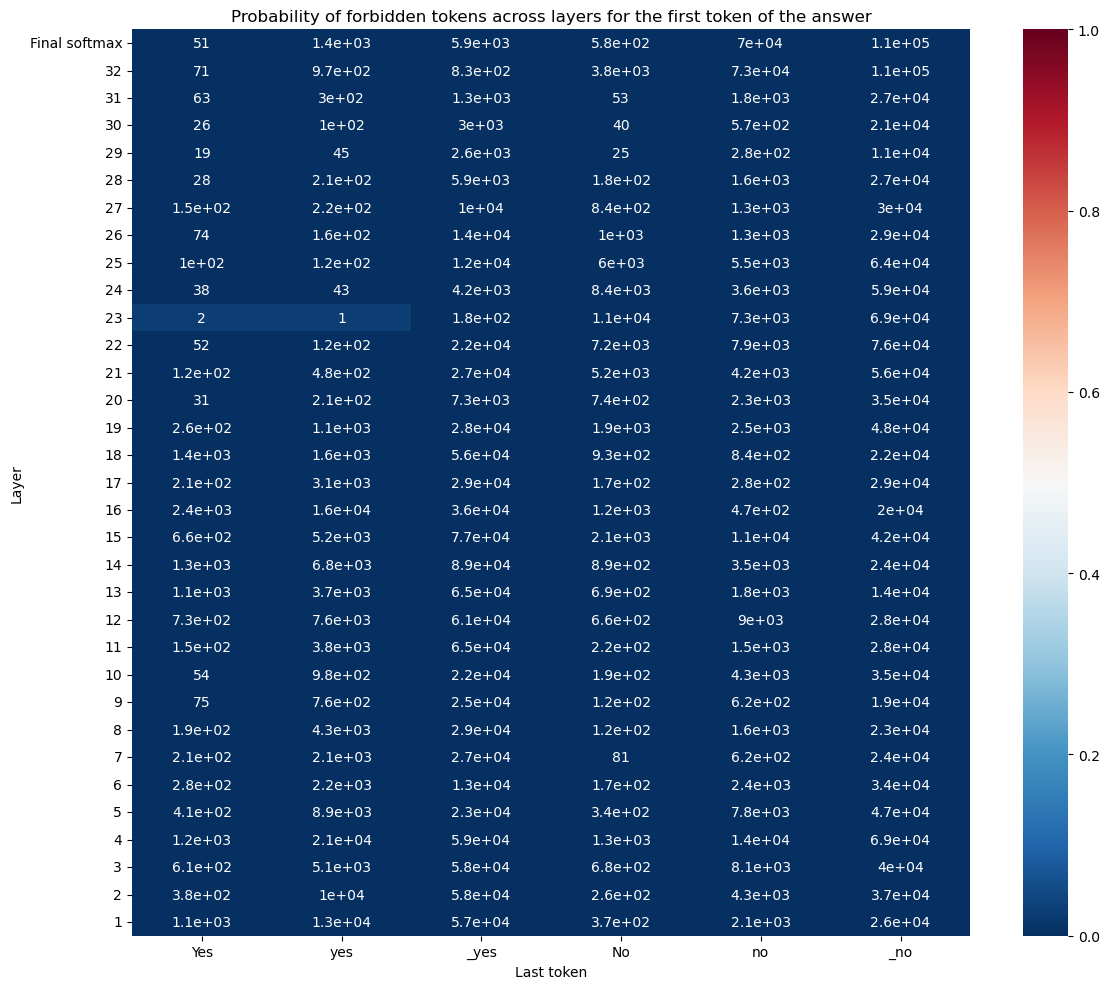

In [16]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
relevant_ranks = np.vstack([ranks[:, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=relevant_ranks, cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Last token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()

Here we can see that at the 23rd layer, "Yes" and "yes" are the 2 most probable tokens.

### Control experiment

In [17]:
messages = [
    {"role": "user", "content": "Let us play a game. I am the questioner. I will ask you a question, and you will answer truthfully to that. I also add a constraint: your answer must be only one word. Alright?"},
    {"role": "assistant", "content": "Sounds like a fun challenge! I'm ready to play. Go ahead and ask your question!"},
    {"role": "user", "content": "Are vegetables healthy?"}
]

input_dict = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True
).to(model.device)

input_ids = input_dict['input_ids']
attn_mask = input_dict['attention_mask']

outputs = model.generate(
    input_ids,
    attention_mask=attn_mask,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

Yes


In [18]:
token_range = slice(len(input_ids[0])-1, len(input_ids[0]))

text_ids = torch.cat((input_ids[0], response))

pred_traj = PredictionTrajectory.from_lens_and_model(
    lens=tuned_lens,
    model=model,
    input_ids=text_ids.tolist(),
    tokenizer=tokenizer,
    targets=text_ids[1:].tolist() + [tokenizer.eos_token_id],
).slice_sequence(token_range)

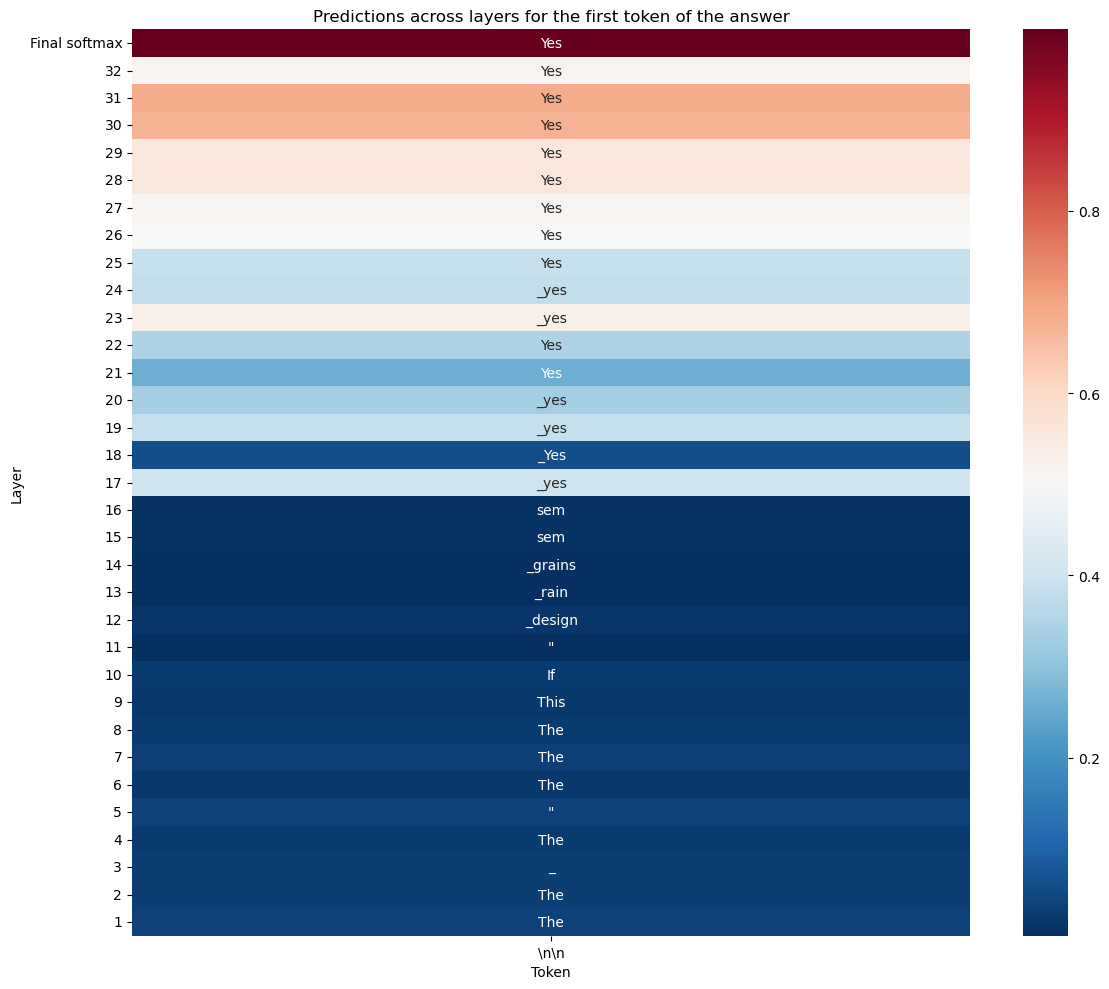

In [19]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
tokens = pred_traj.max_probability().sequence_labels

stats = pred_traj.max_probability().stats[::-1, :]
preds = pred_traj.max_probability().trajectory_labels.label_strings[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))

# Create the heatmap using seaborn
ax = sns.heatmap(stats, cmap="RdBu_r", annot=preds, 
                fmt="", cbar=True)

# Set labels and title
ax.set_xlabel('Token')
ax.set_ylabel('Layer')
ax.set_title('Predictions across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(stats), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, stats.shape[1], 1))
ax.set_xticklabels(tokens)

# Adjust layout
plt.tight_layout()
plt.show()

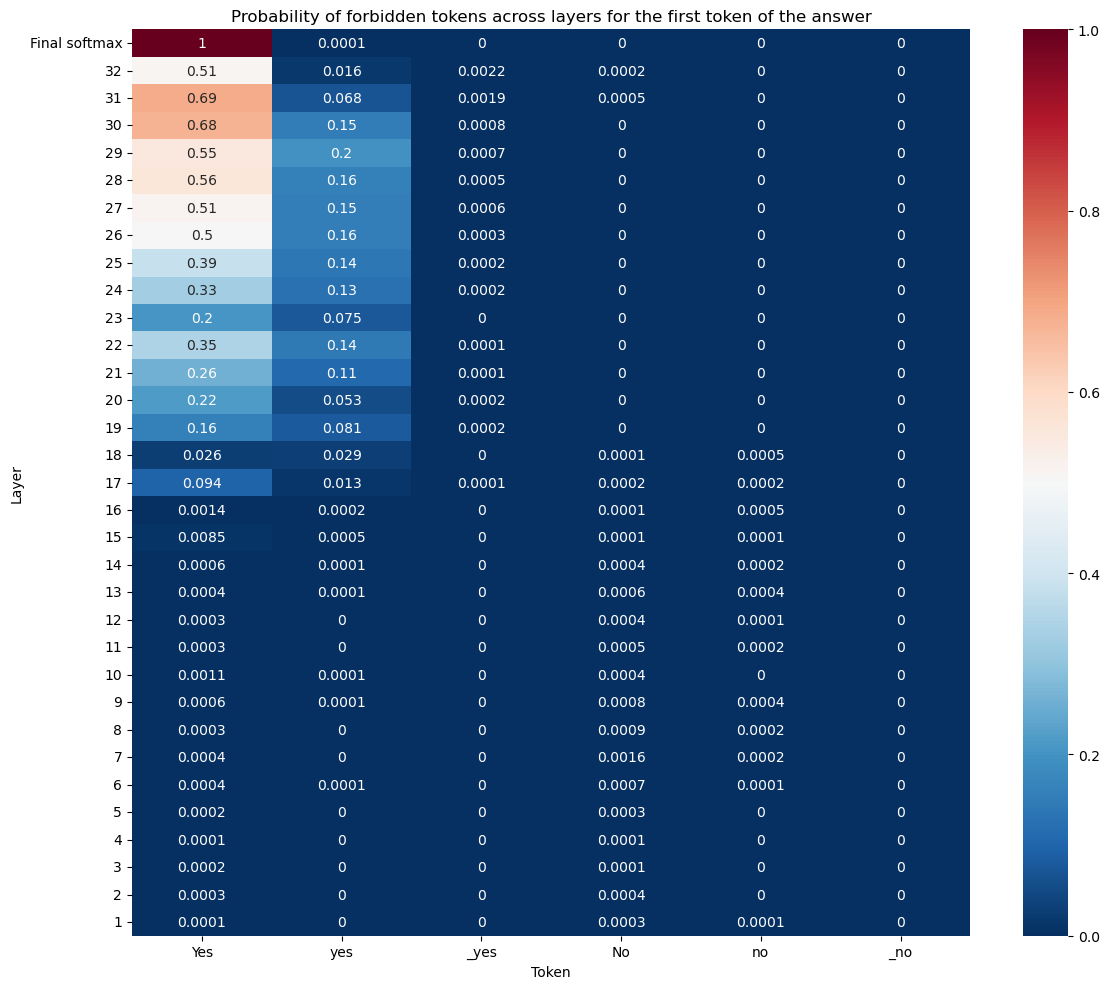

In [20]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
probs = np.vstack([pred_traj.probs[:, 0, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=probs.round(4), cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()

In [21]:
order = (-pred_traj.probs[:, 0, :]).argsort()
ranks = order.argsort() + 1

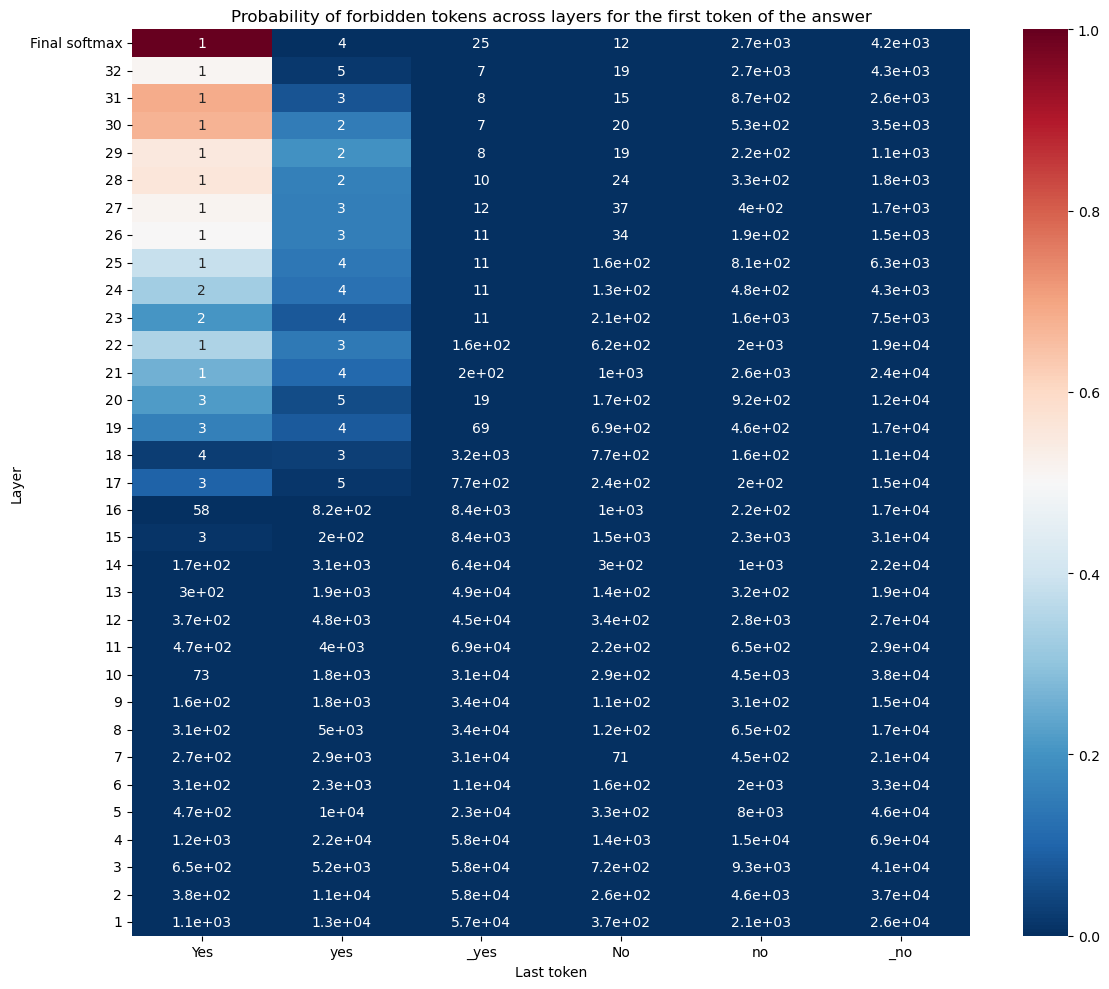

In [22]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
relevant_ranks = np.vstack([ranks[:, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=relevant_ranks, cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Last token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()

Here we can see that "Yes" becomes very likely from the 15th layer, so earlier than in the game case.

## Second example: Is Paris the capital of France?

### Yes, no, black, white

In [23]:
messages = [
    {"role": "user", "content": "Let us play the game Yes, no, black, white. I am the questioner. I will ask you a question, and you will answer truthfully to that without using any of the four forbidden words: yes, no, black or white. If you use one of the forbidden words, you lose. I also add a constraint: your answer must be only one word. Alright?"},
    {"role": "assistant", "content": "Sounds like a fun challenge! I'm ready to play. Go ahead and ask your question!"},
    {"role": "user", "content": "Is Paris the capital of France?"}
]

input_dict = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True
).to(model.device)

input_ids = input_dict['input_ids']
attn_mask = input_dict['attention_mask']

outputs = model.generate(
    input_ids,
    attention_mask=attn_mask,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

City


In [24]:
token_range = slice(len(input_ids[0])-1, len(input_ids[0]))

text_ids = torch.cat((input_ids[0], response))

pred_traj = PredictionTrajectory.from_lens_and_model(
    lens=tuned_lens,
    model=model,
    input_ids=text_ids.tolist(),
    tokenizer=tokenizer,
    targets=text_ids[1:].tolist() + [tokenizer.eos_token_id],
).slice_sequence(token_range)

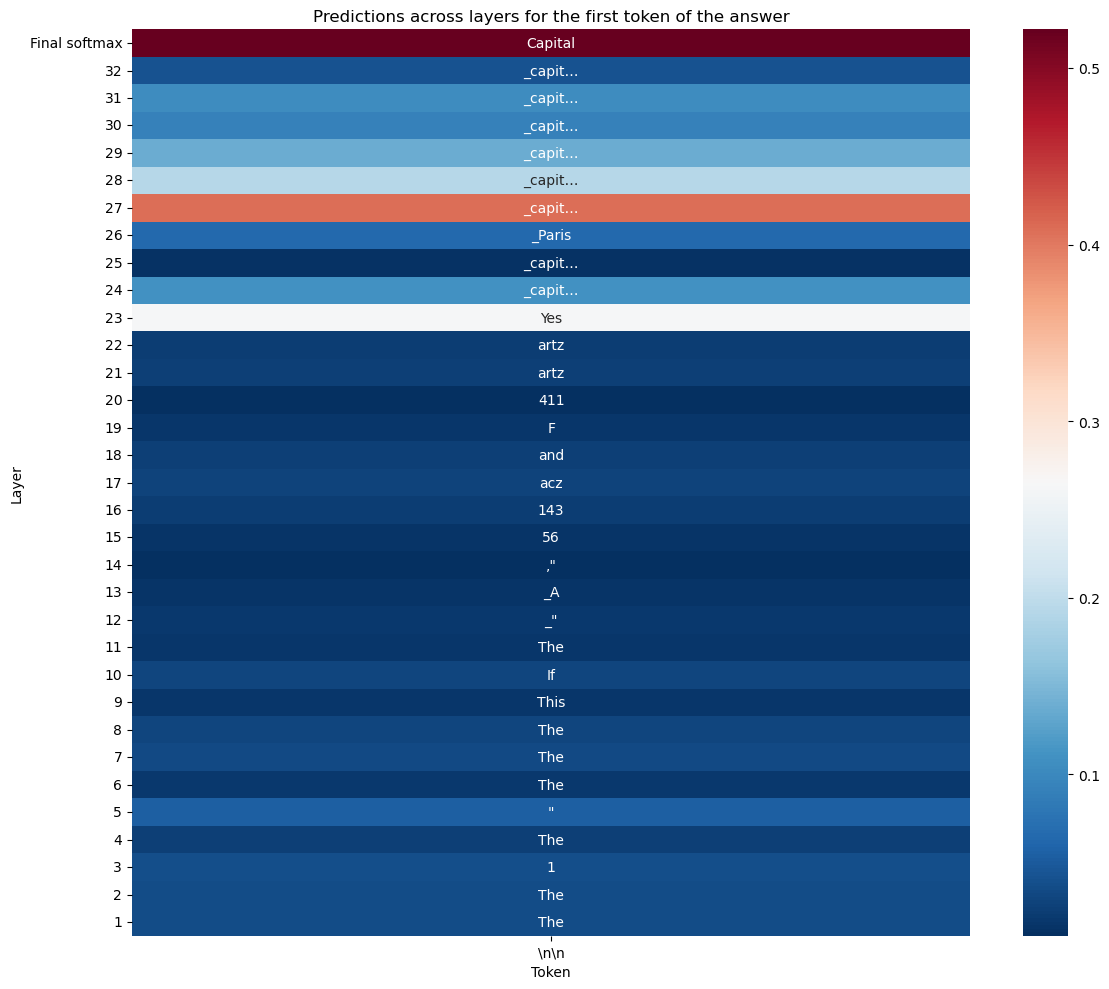

In [25]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
tokens = pred_traj.max_probability().sequence_labels

stats = pred_traj.max_probability().stats[::-1, :]
preds = pred_traj.max_probability().trajectory_labels.label_strings[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))

# Create the heatmap using seaborn
ax = sns.heatmap(stats, cmap="RdBu_r", annot=preds, 
                fmt="", cbar=True)

# Set labels and title
ax.set_xlabel('Token')
ax.set_ylabel('Layer')
ax.set_title('Predictions across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(stats), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, stats.shape[1], 1))
ax.set_xticklabels(tokens)

# Adjust layout
plt.tight_layout()
plt.show()

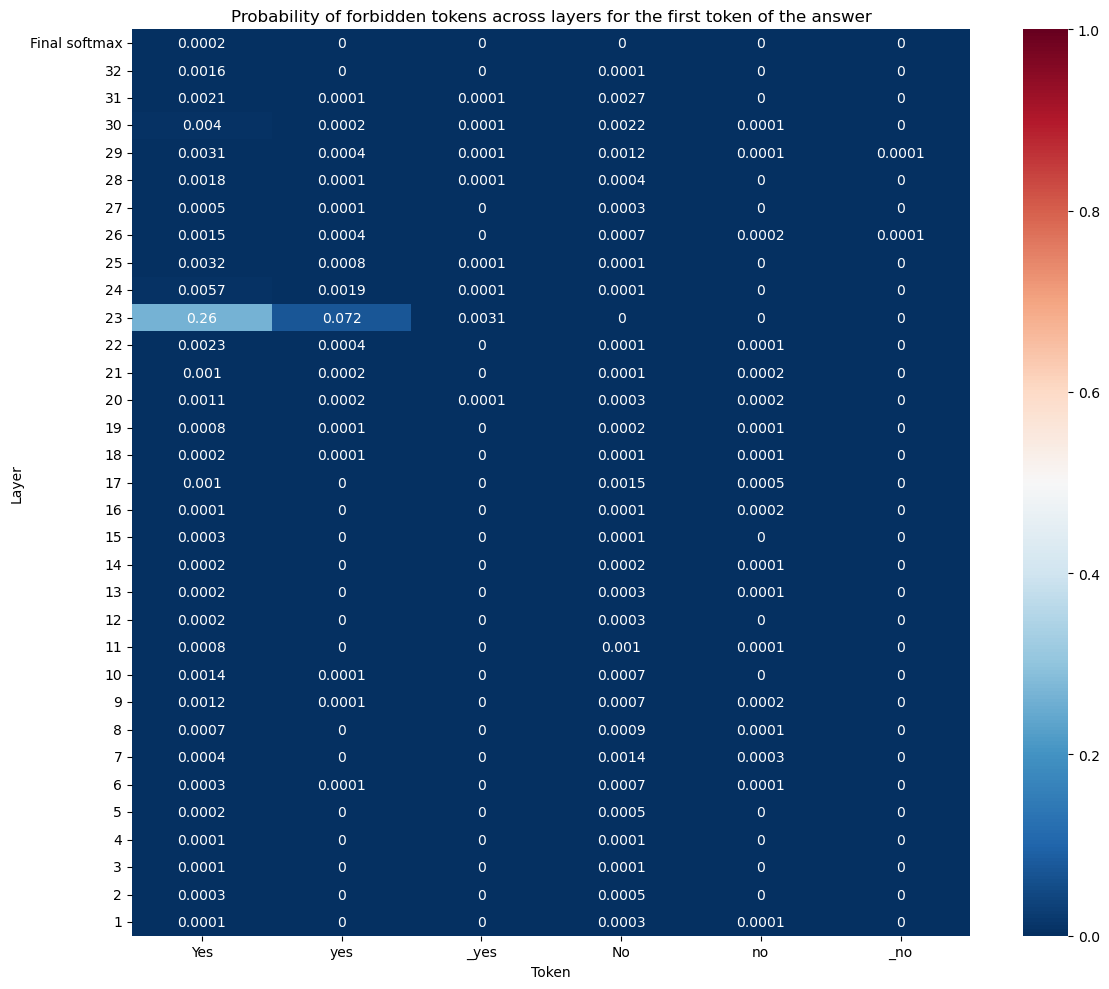

In [26]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
probs = np.vstack([pred_traj.probs[:, 0, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=probs.round(4), cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()

In [27]:
order = (-pred_traj.probs[:, 0, :]).argsort()
ranks = order.argsort() + 1

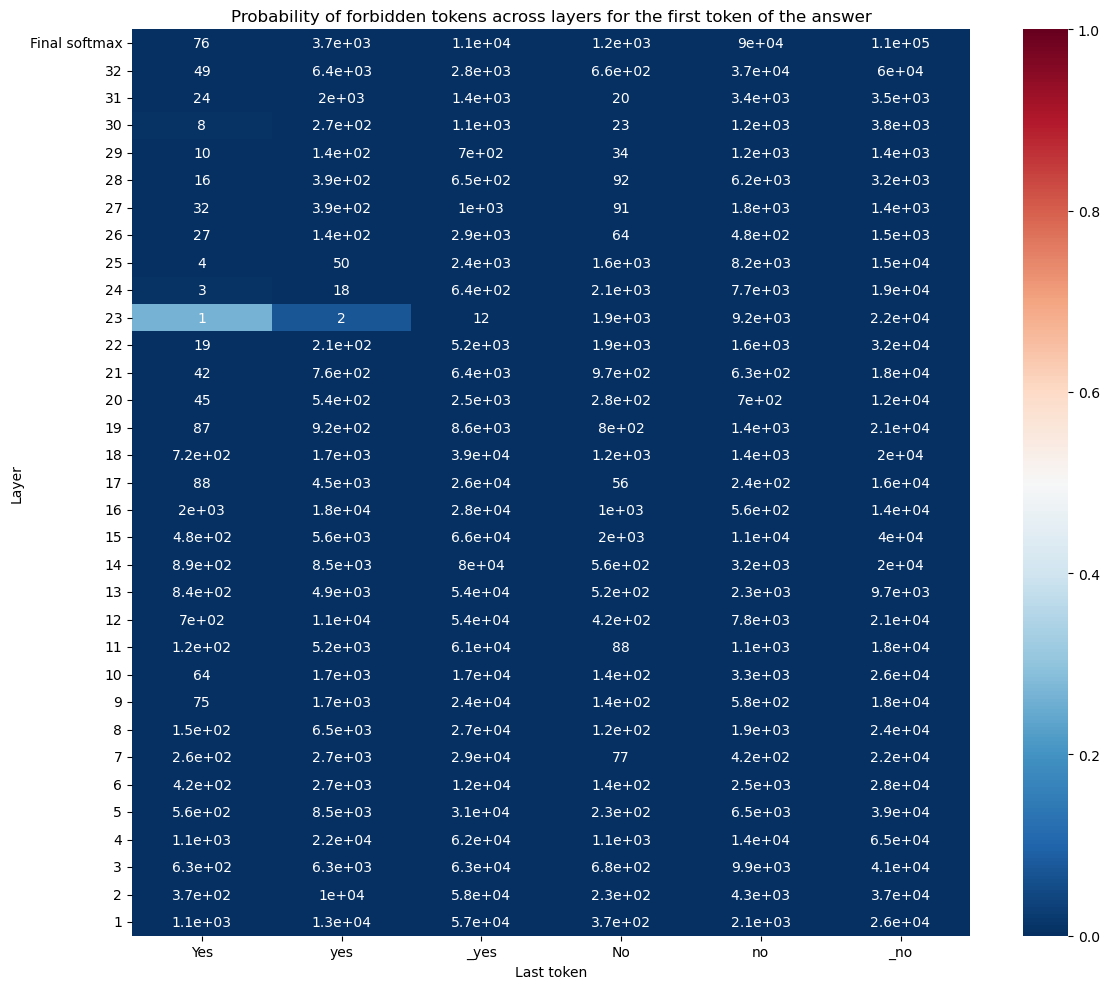

In [28]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
relevant_ranks = np.vstack([ranks[:, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=relevant_ranks, cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Last token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()

### Control experiment

In [29]:
messages = [
    {"role": "user", "content": "Let us play a game. I am the questioner. I will ask you a question, and you will answer truthfully to that. I also add a constraint: your answer must be only one word. Alright?"},
    {"role": "assistant", "content": "Sounds like a fun challenge! I'm ready to play. Go ahead and ask your question!"},
    {"role": "user", "content": "Is Paris the capital of France?"}
]

input_dict = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True
).to(model.device)

input_ids = input_dict['input_ids']
attn_mask = input_dict['attention_mask']

outputs = model.generate(
    input_ids,
    attention_mask=attn_mask,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

Oui


In [30]:
token_range = slice(len(input_ids[0])-1, len(input_ids[0]))

text_ids = torch.cat((input_ids[0], response))

pred_traj = PredictionTrajectory.from_lens_and_model(
    lens=tuned_lens,
    model=model,
    input_ids=text_ids.tolist(),
    tokenizer=tokenizer,
    targets=text_ids[1:].tolist() + [tokenizer.eos_token_id],
).slice_sequence(token_range)

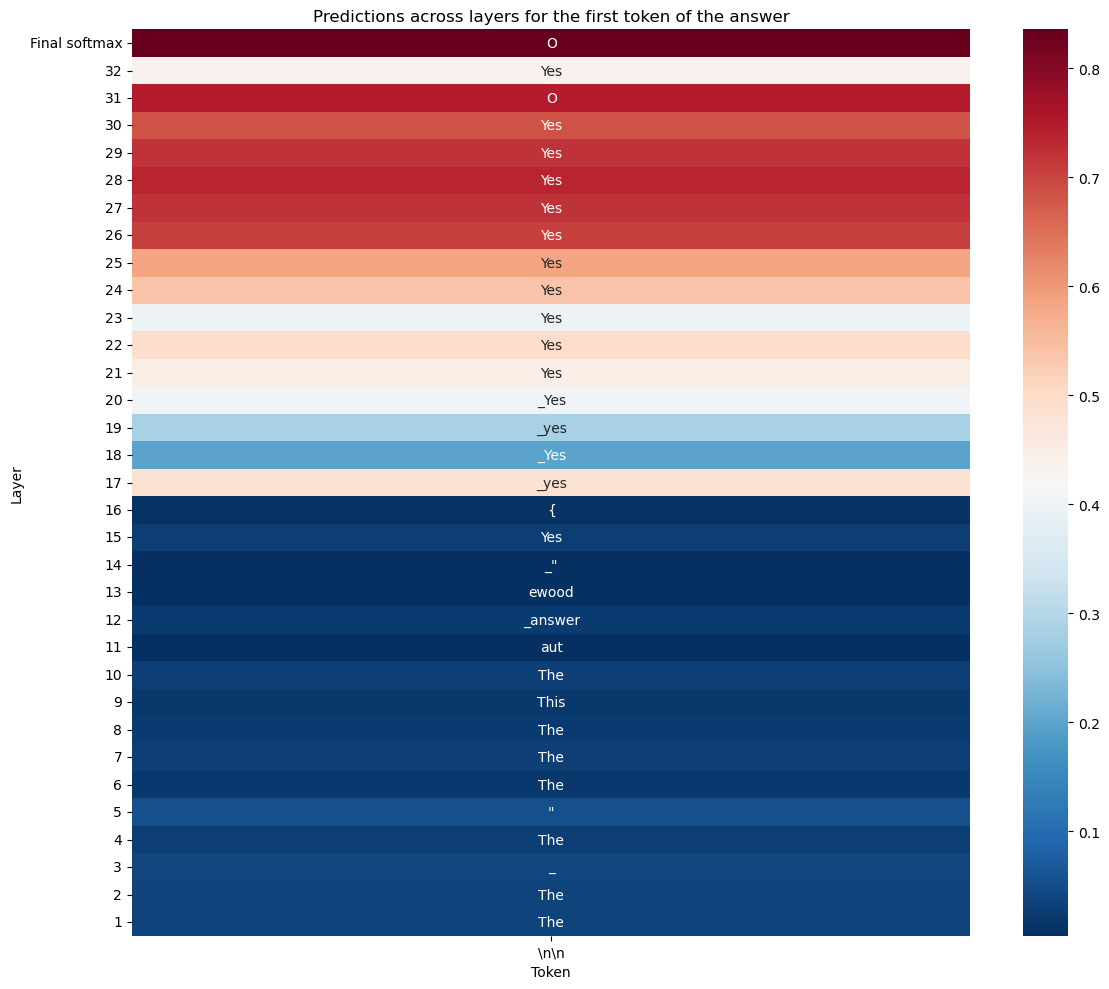

In [31]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
tokens = pred_traj.max_probability().sequence_labels

stats = pred_traj.max_probability().stats[::-1, :]
preds = pred_traj.max_probability().trajectory_labels.label_strings[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))

# Create the heatmap using seaborn
ax = sns.heatmap(stats, cmap="RdBu_r", annot=preds, 
                fmt="", cbar=True)

# Set labels and title
ax.set_xlabel('Token')
ax.set_ylabel('Layer')
ax.set_title('Predictions across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(stats), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, stats.shape[1], 1))
ax.set_xticklabels(tokens)

# Adjust layout
plt.tight_layout()
plt.show()

It was unexpected but the model took the initiative to answer in French: Oui. The token 'O' is chosen only in the very last layers.

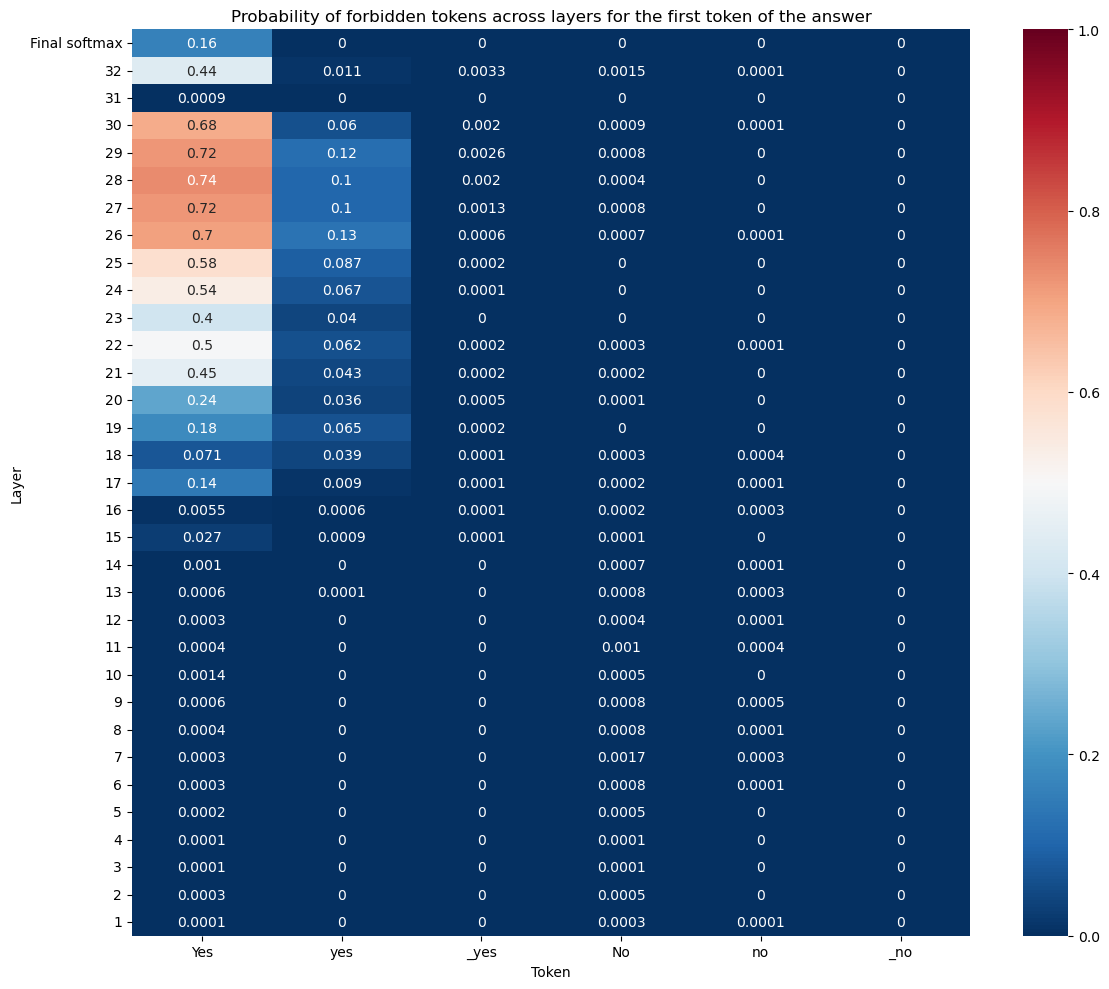

In [32]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
probs = np.vstack([pred_traj.probs[:, 0, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=probs.round(4), cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()

In [33]:
order = (-pred_traj.probs[:, 0, :]).argsort()
ranks = order.argsort() + 1

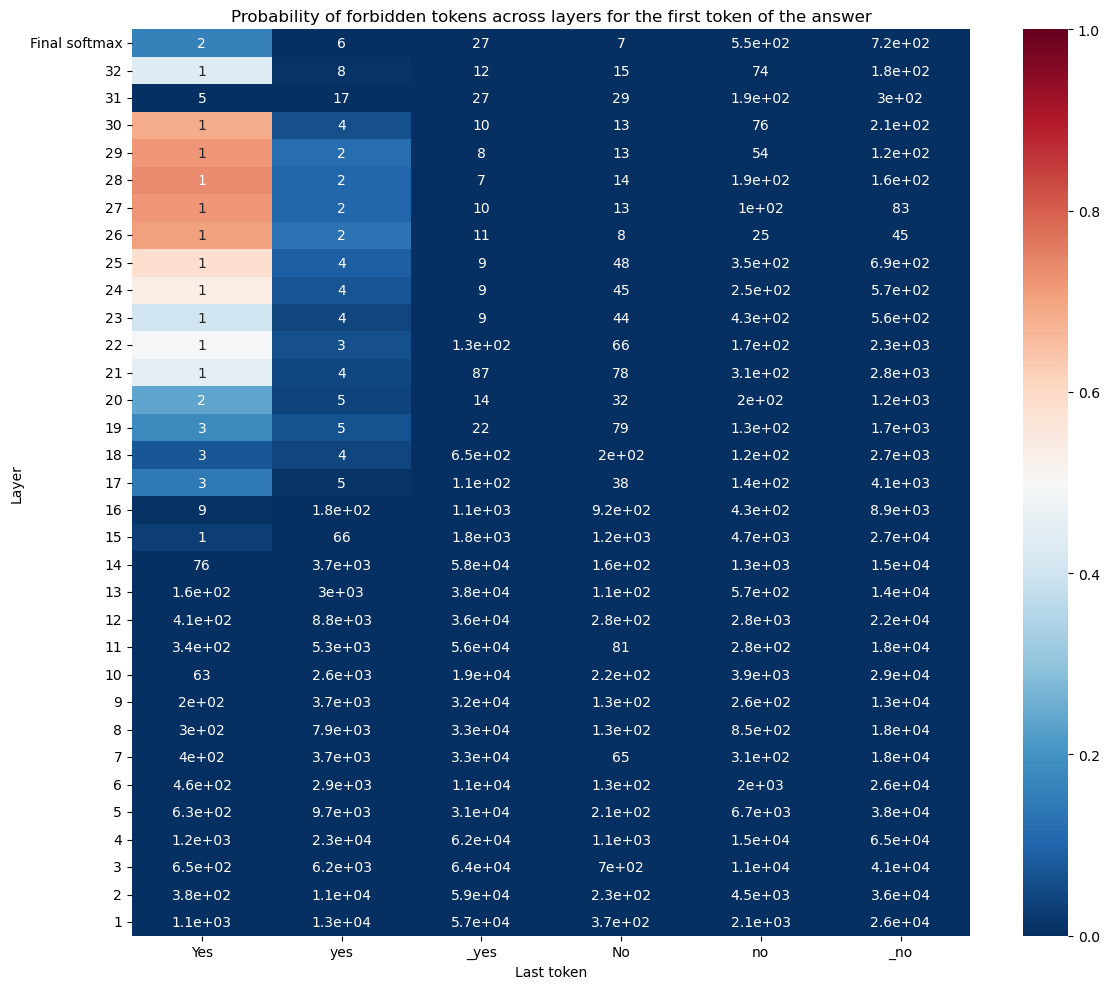

In [34]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
relevant_ranks = np.vstack([ranks[:, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=relevant_ranks, cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Last token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()

## Third example: Is Magnus Carlsen a famous chef?

### Yes, no, black, white

In [35]:
messages = [
    {"role": "user", "content": "Let us play the game Yes, no, black, white. I am the questioner. I will ask you a question, and you will answer truthfully to that without using any of the four forbidden words: yes, no, black or white. If you use one of the forbidden words, you lose. I also add a constraint: your answer must be only one word. Alright?"},
    {"role": "assistant", "content": "Sounds like a fun challenge! I'm ready to play. Go ahead and ask your question!"},
    {"role": "user", "content": "Is Magnus Carlsen a famous chef?"}
]

input_dict = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True
).to(model.device)

input_ids = input_dict['input_ids']
attn_mask = input_dict['attention_mask']

outputs = model.generate(
    input_ids,
    attention_mask=attn_mask,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

Talent


In [36]:
token_range = slice(len(input_ids[0])-1, len(input_ids[0]))

text_ids = torch.cat((input_ids[0], response))

pred_traj = PredictionTrajectory.from_lens_and_model(
    lens=tuned_lens,
    model=model,
    input_ids=text_ids.tolist(),
    tokenizer=tokenizer,
    targets=text_ids[1:].tolist() + [tokenizer.eos_token_id],
).slice_sequence(token_range)

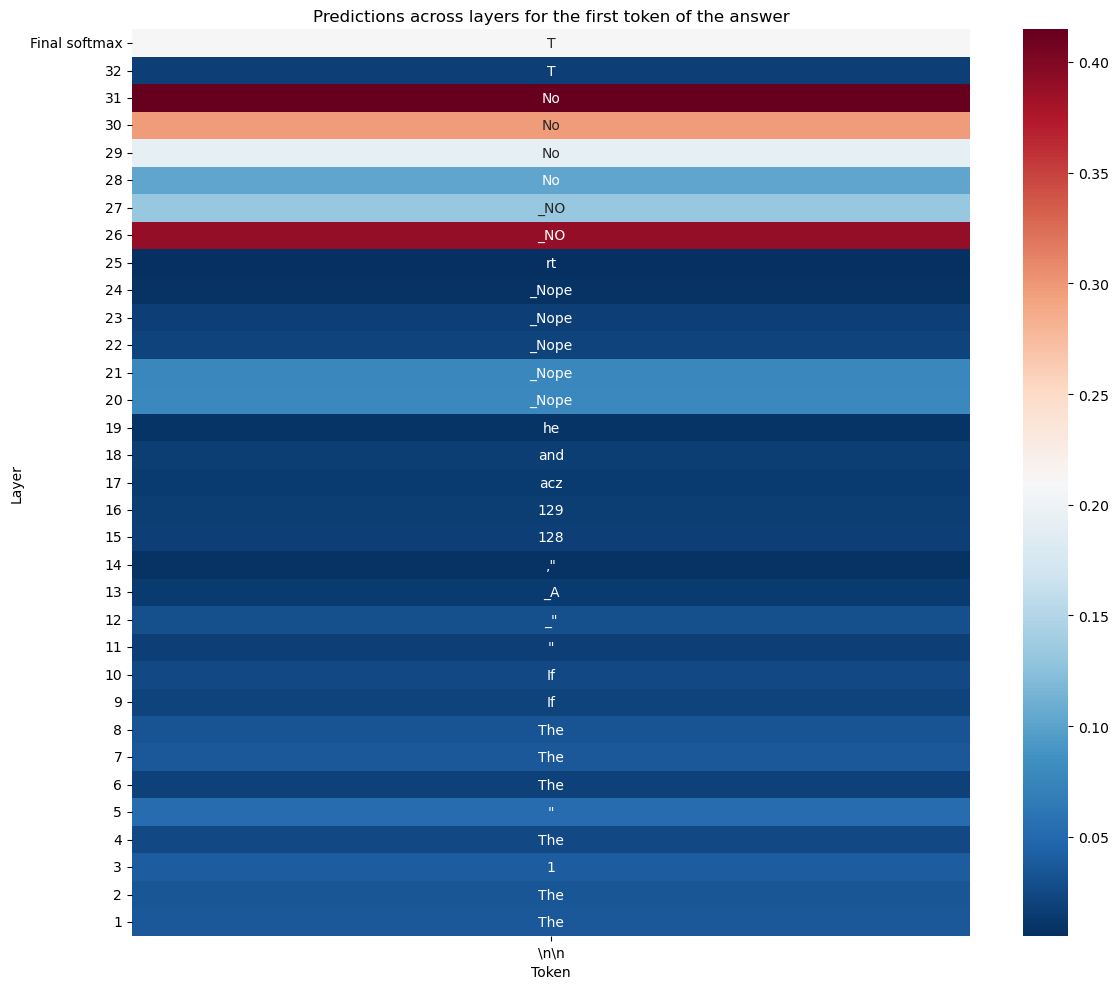

In [37]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
tokens = pred_traj.max_probability().sequence_labels

stats = pred_traj.max_probability().stats[::-1, :]
preds = pred_traj.max_probability().trajectory_labels.label_strings[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))

# Create the heatmap using seaborn
ax = sns.heatmap(stats, cmap="RdBu_r", annot=preds, 
                fmt="", cbar=True)

# Set labels and title
ax.set_xlabel('Token')
ax.set_ylabel('Layer')
ax.set_title('Predictions across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(stats), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, stats.shape[1], 1))
ax.set_xticklabels(tokens)

# Adjust layout
plt.tight_layout()
plt.show()

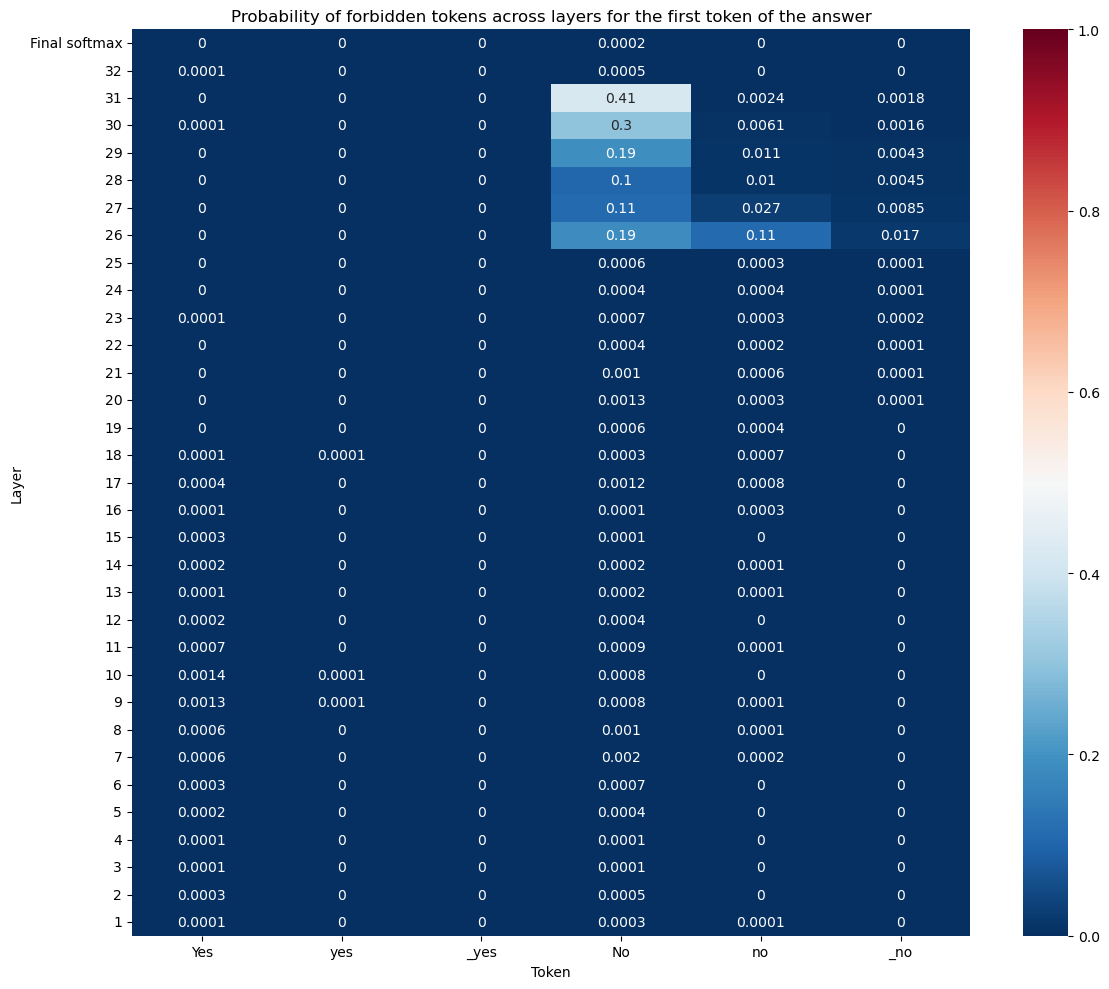

In [38]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
probs = np.vstack([pred_traj.probs[:, 0, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=probs.round(4), cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()

In [39]:
order = (-pred_traj.probs[:, 0, :]).argsort()
ranks = order.argsort() + 1

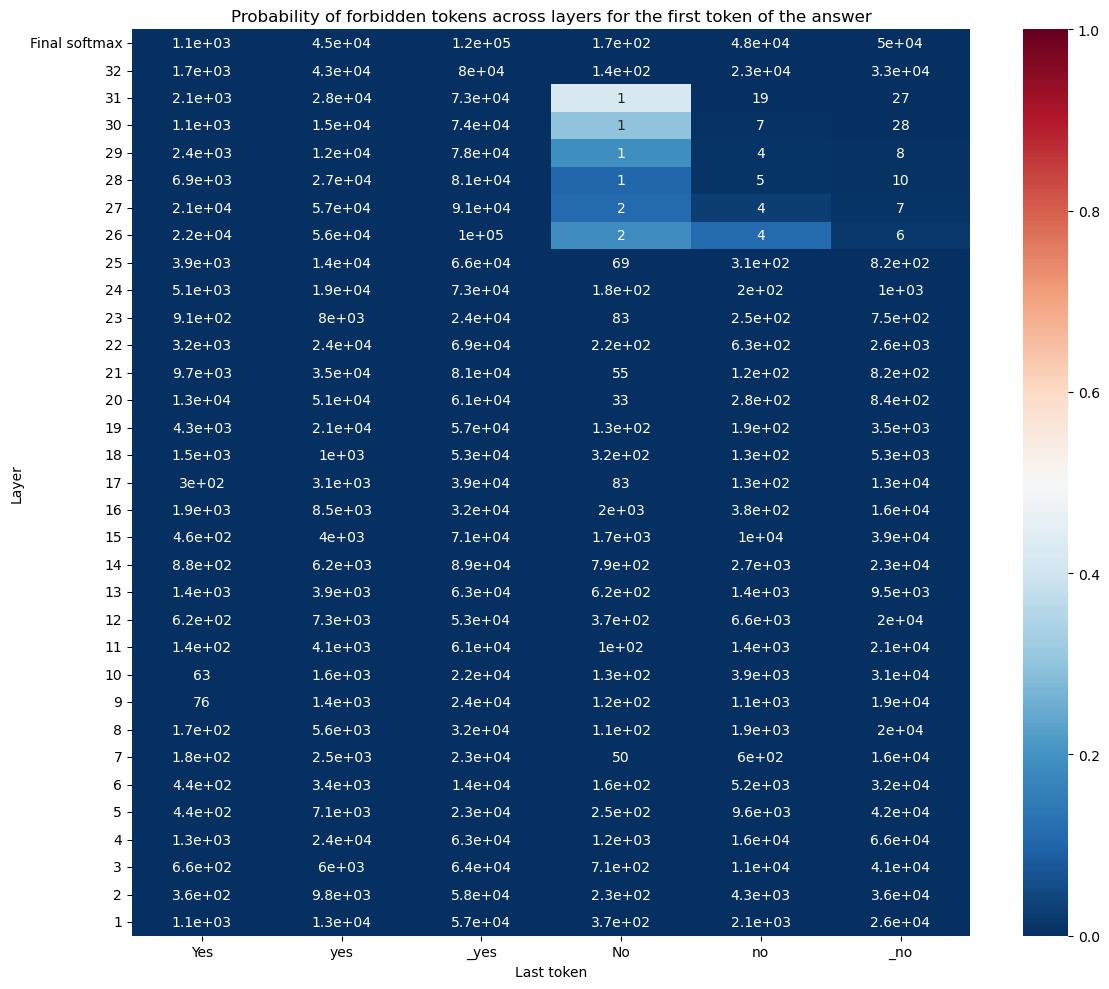

In [40]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
relevant_ranks = np.vstack([ranks[:, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=relevant_ranks, cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Last token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()

### Control experiment

In [41]:
messages = [
    {"role": "user", "content": "Let us play a game. I am the questioner. I will ask you a question, and you will answer truthfully to that. I also add a constraint: your answer must be only one word. Alright?"},
    {"role": "assistant", "content": "Sounds like a fun challenge! I'm ready to play. Go ahead and ask your question!"},
    {"role": "user", "content": "Is Magnus Carlsen a famous chef?"}
]

input_dict = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True
).to(model.device)

input_ids = input_dict['input_ids']
attn_mask = input_dict['attention_mask']

outputs = model.generate(
    input_ids,
    attention_mask=attn_mask,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

No.


In [42]:
token_range = slice(len(input_ids[0])-1, len(input_ids[0]))

text_ids = torch.cat((input_ids[0], response))

pred_traj = PredictionTrajectory.from_lens_and_model(
    lens=tuned_lens,
    model=model,
    input_ids=text_ids.tolist(),
    tokenizer=tokenizer,
    targets=text_ids[1:].tolist() + [tokenizer.eos_token_id],
).slice_sequence(token_range)

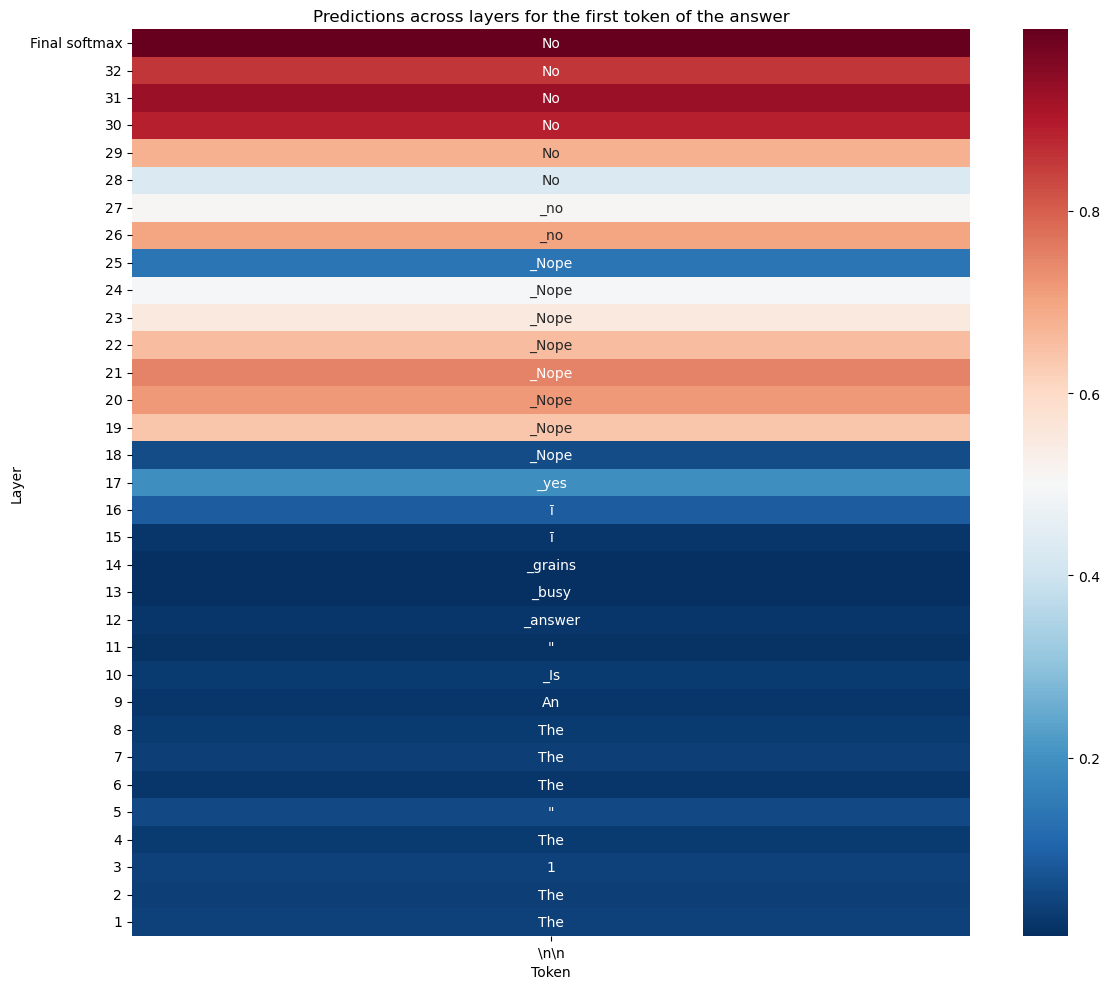

In [43]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
tokens = pred_traj.max_probability().sequence_labels

stats = pred_traj.max_probability().stats[::-1, :]
preds = pred_traj.max_probability().trajectory_labels.label_strings[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))

# Create the heatmap using seaborn
ax = sns.heatmap(stats, cmap="RdBu_r", annot=preds, 
                fmt="", cbar=True)

# Set labels and title
ax.set_xlabel('Token')
ax.set_ylabel('Layer')
ax.set_title('Predictions across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(stats), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, stats.shape[1], 1))
ax.set_xticklabels(tokens)

# Adjust layout
plt.tight_layout()
plt.show()

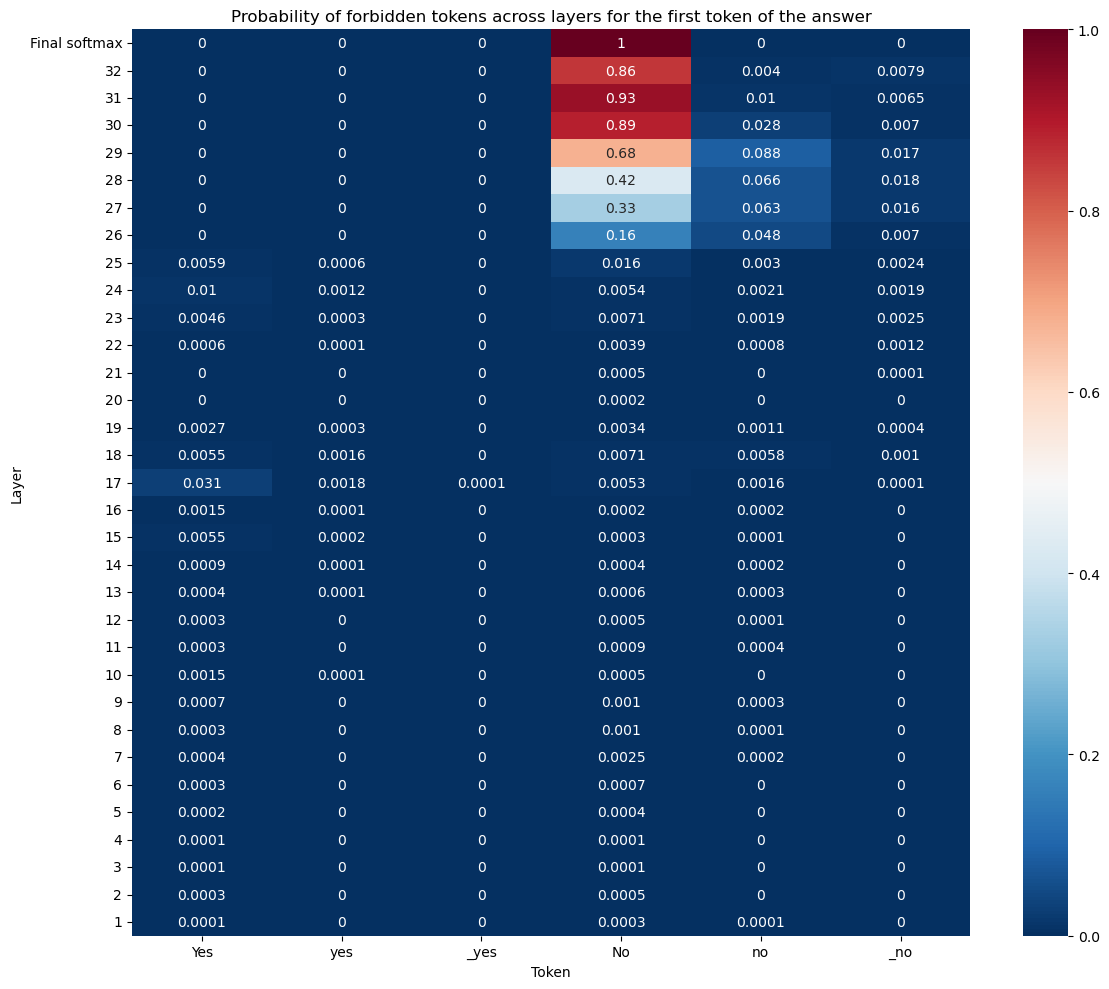

In [44]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
probs = np.vstack([pred_traj.probs[:, 0, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=probs.round(4), cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()

In [45]:
order = (-pred_traj.probs[:, 0, :]).argsort()
ranks = order.argsort() + 1

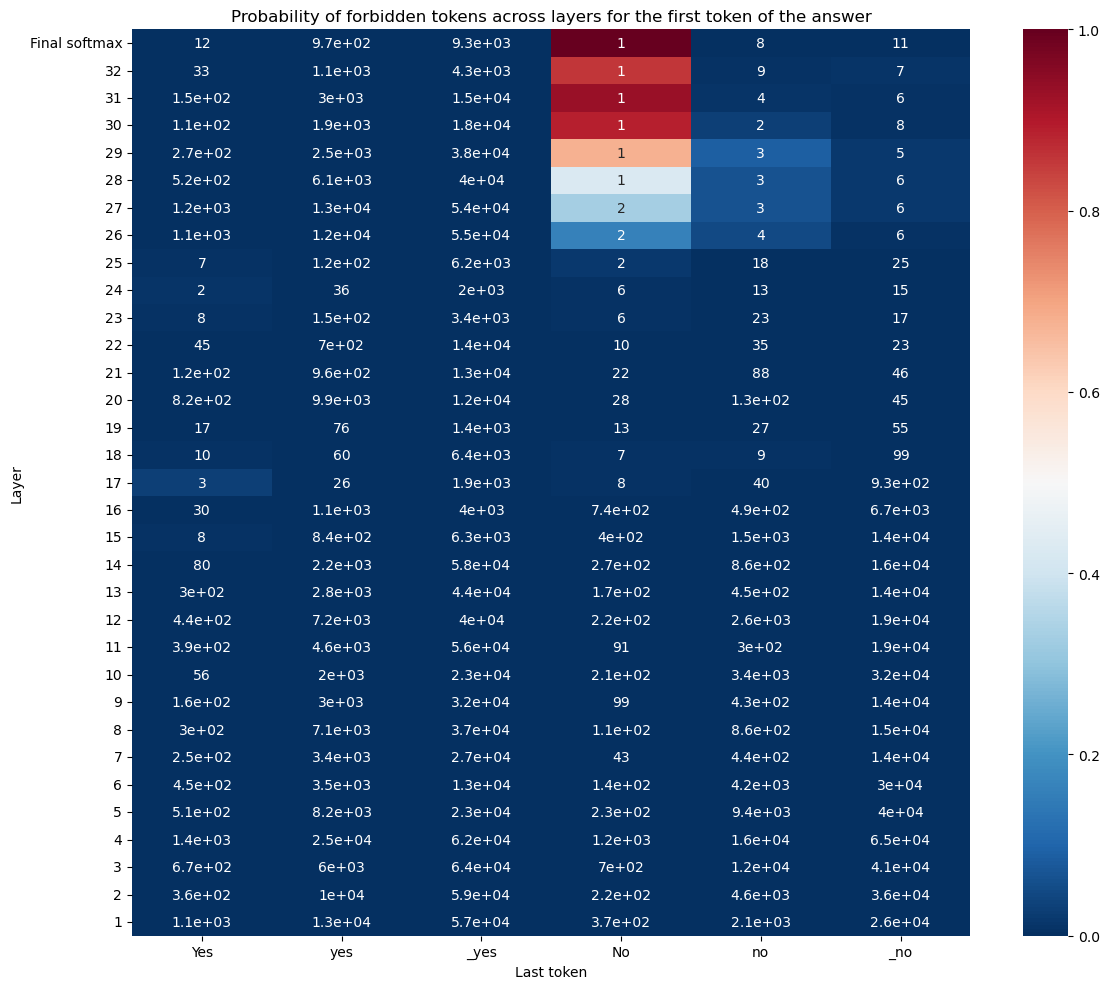

In [46]:
layers = [i+1 for i in range(32)] + ['Final softmax']
layers = layers[::-1]
relevant_tokens = ['Yes', 'yes', '_yes', 'No', 'no', '_no'] #, 'Black', 'black', '_black', 'White', 'white', '_white']
relevant_ranks = np.vstack([ranks[:, tokenizer.vocab[tok]] for tok in relevant_tokens]).T[::-1, :]

# Create figure and axes
plt.figure(figsize=(12, 10))
ax = sns.heatmap(probs, cmap="RdBu_r", annot=relevant_ranks, cbar=True, vmin=0, vmax=1)

# Set labels and title
ax.set_xlabel('Last token')
ax.set_ylabel('Layer')
ax.set_title('Probability of forbidden tokens across layers for the first token of the answer')

# Set y-axis ticks to start from 0 at the bottom
plt.yticks(rotation=0)
ax.set_yticks(np.arange(0.5, len(probs), 1))
ax.set_yticklabels(layers)

# Set x-axis ticks
ax.set_xticks(np.arange(0.5, probs.shape[1], 1))
ax.set_xticklabels(relevant_tokens)

# Adjust layout
plt.tight_layout()
plt.show()